In [ ]:
################## Imports ##################
## Pandas
import pandas as pd
## Matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.patches import Circle
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
## Math
import math
## Numpy
import numpy as np
## tdqm
from tqdm import tqdm
## Scipy
from scipy.spatial import Voronoi, voronoi_plot_2d
## Shapely
from shapely.geometry import Polygon, LineString, Point, LinearRing
from shapely.ops import unary_union
from shapely.errors import GEOSException
## Random
import random
## json
import json

################## Options ##################
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)
plt.rc("animation", html="html5")

# Import and transform the data

## Import the data

In [12]:
# Game 1
game_1_events = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2025/releases/download/Data/2024-10-25.Team.H.@.Team.G.-.Events.csv", low_memory=False)
game_1_shifts = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2025/releases/download/Data/2024-10-25.Team.H.@.Team.G.-.Shifts.csv", low_memory=False)
game_1_tracking = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2025/releases/download/Data/2024-10-25.Team.H.@.Team.G.-.Tracking.csv", low_memory=False)
# Game 2
game_2_events = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2025/releases/download/Data/2024-11-15.Team.D.@.Team.C.-.Events.csv", low_memory=False)
game_2_shifts = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2025/releases/download/Data/2024-11-15.Team.D.@.Team.C.-.Shifts.csv", low_memory=False)
game_2_tracking = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2025/releases/download/Data/2024-11-15.Team.D.@.Team.C.-.Tracking.csv", low_memory=False)
# Game 3
game_3_events = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2025/releases/download/Data/2024-11-16.Team.F.@.Team.E.-.Events.csv", low_memory=False)
game_3_shifts = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2025/releases/download/Data/2024-11-16.Team.F.@.Team.E.-.Shifts.csv", low_memory=False)
game_3_tracking = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2025/releases/download/Data/2024-11-16.Team.F.@.Team.E.-.Tracking.csv", low_memory=False)

## Transform the data

### Add the 'Puck' as team and change the game clock in seconds.

In [13]:
############################## Game 1 ##############################
# We add 'Puck' in team
game_1_tracking["Team"] = game_1_tracking["Team"].fillna("Puck")
# We add the time in seconds
game_1_tracking["Game Clock Sec"] = game_1_tracking["Game Clock"].str.split(":").str[0].astype(float)*60 + game_1_tracking["Game Clock"].str.split(":").str[1].astype(float)
game_1_events["Clock Sec"] = game_1_events["Clock"].str.split(":").str[0].astype(float)*60 + game_1_events["Clock"].str.split(":").str[1].astype(float)

############################## Game 2 ##############################
# We add 'Puck' in team
game_2_tracking["Team"] = game_2_tracking["Team"].fillna("Puck")
# We add the time in seconds
game_2_tracking["Game Clock Sec"] = game_2_tracking["Game Clock"].str.split(":").str[0].astype(float)*60 + game_2_tracking["Game Clock"].str.split(":").str[1].astype(float)
game_2_events["Clock Sec"] = game_2_events["Clock"].str.split(":").str[0].astype(float)*60 + game_2_events["Clock"].str.split(":").str[1].astype(float)

############################## Game 3 ##############################
# We add 'Puck' in team
game_3_tracking["Team"] = game_3_tracking["Team"].fillna("Puck")
# We add the time in seconds
game_3_tracking["Game Clock Sec"] = game_3_tracking["Game Clock"].str.split(":").str[0].astype(float)*60 + game_3_tracking["Game Clock"].str.split(":").str[1].astype(float)
game_3_events["Clock Sec"] = game_3_events["Clock"].str.split(":").str[0].astype(float)*60 + game_3_events["Clock"].str.split(":").str[1].astype(float)

### Add the frame where the player is the closest to the puck for an event

#### Function

In [14]:
def get_event_player_closest_opponent(tracking_data, period, time_in_sec, player_id, player_team) :
  tracking_data_subset = tracking_data[(tracking_data["Period"] == period) & (tracking_data["Game Clock Sec"].isin(list(range(time_in_sec+2, time_in_sec-3, -1))))].reset_index(drop=True)
  # Set the dataframe which will be the one where the selected player is the closest to the puck
  current_data = pd.DataFrame()
  # Set the current distance between the selected player and the puck
  current_dist = 100000
  # Set the current img
  current_img = ""
  # Apply the loop on the different images
  for img_id in list(pd.unique(tracking_data_subset["Image Id"])) :
    # Tracking data of the image
    data_img = tracking_data_subset[tracking_data_subset["Image Id"] == img_id].reset_index(drop=True)
    # Puck data
    data_img_puck = data_img[data_img["Team"] == "Puck"].reset_index(drop=True)
    # Player data
    data_img_player = data_img[(data_img["Team"] == player_team) & (data_img["Player Id"] == player_id)].reset_index(drop=True)
    if len(data_img_puck) > 0 and len(data_img_player) > 0 :
      # Progression of the puck towards the player
      player_puck_dist = math.sqrt((data_img_player.loc[0, "Rink Location X (Feet)"] - data_img_puck.loc[0, "Rink Location X (Feet)"])**2 + (data_img_player.loc[0, "Rink Location Y (Feet)"] - data_img_puck.loc[0, "Rink Location Y (Feet)"])**2)
      if player_puck_dist < current_dist :
        # Set the current dataframe
        current_data = data_img
        # Set the current closest dist
        current_dist = player_puck_dist
        # Set the current frame (img)
        current_img = img_id
  # Player coordinates at the 'current frame'
  if len(current_data) > 0 :
    current_data_player = current_data[current_data["Player Id"] == player_id].reset_index(drop=True)
    current_data_player_x = current_data_player.loc[0, "Rink Location X (Feet)"]
    current_data_player_y = current_data_player.loc[0, "Rink Location Y (Feet)"]
    # Get closest player
    current_data_opp_player = current_data[~current_data["Team"].isin(["Puck"])].reset_index(drop=True)
    if len(current_data_opp_player) > 0 :
      current_data_opp_player["Dist to player"] = np.sqrt((current_data_opp_player["Rink Location X (Feet)"] - current_data_player_x)**2 + (current_data_opp_player["Rink Location Y (Feet)"] - current_data_player_y)**2)
      current_data_opp_player = current_data_opp_player.sort_values(by="Dist to player", ascending=True)
      closest_player_dist = current_data_opp_player.loc[0, "Dist to player"]
      closest_player_id = current_data_opp_player.loc[0, "Player Id"]
      return {"Closest Dist" : closest_player_dist, "Closest Id" : closest_player_id, "Closest Dist Img" : current_img}
    else :
      return {"Closest Dist" : pd.NA, "Closest Id" : pd.NA, "Closest Dist Img" : pd.NA}
  else :
    return {"Closest Dist" : pd.NA, "Closest Id" : pd.NA, "Closest Dist Img" : pd.NA}

#### Apply the function

In our study, we will only focus on 'Play' events. We filter the **events** dataframe to only keep the **Play** events.

In [15]:
# Game 1
play_events_game_1 = game_1_events[game_1_events["Event"].isin(["Play"])].reset_index(drop=True)
# Game 2
play_events_game_2 = game_2_events[game_2_events["Event"].isin(["Play"])].reset_index(drop=True)
# Game 3
play_events_game_3 = game_3_events[game_3_events["Event"].isin(["Play"])].reset_index(drop=True)

In [ ]:
# Game 1
for i in tqdm(range(len(play_events_game_1)), desc="Processing") :
  # Get period
  period = play_events_game_1.loc[i, "Period"]
  # Get Clock time in sec
  clock_sec = play_events_game_1.loc[i, "Clock Sec"]
  # Player Id
  player_id = play_events_game_1.loc[i, "Player_Id"]
  # Player Team
  first_team = play_events_game_1.loc[i, "Team"]
  if play_events_game_1.loc[i,"Home_Team"] == first_team :
    player_team = "Home"
  else :
    player_team = "Away"
  result = get_event_player_closest_opponent(game_1_tracking, period, int(clock_sec), player_id, player_team)
  # Add the result to the 'Event' dataframe
  play_events_game_1.loc[i, "Closest Opp Dist"] = result["Closest Dist"]
  play_events_game_1.loc[i, "Closest Opp Id"] = result["Closest Id"]
  play_events_game_1.loc[i, "Closest Dist Img"] = result["Closest Dist Img"]

# Game 2
for i in tqdm(range(len(play_events_game_2)), desc="Processing") :
  # Get period
  period = play_events_game_2.loc[i, "Period"]
  # Get Clock time in sec
  clock_sec = play_events_game_2.loc[i, "Clock Sec"]
  # Player Id
  player_id = play_events_game_2.loc[i, "Player_Id"]
  # Player Team
  first_team = play_events_game_2.loc[i, "Team"]
  if play_events_game_2.loc[i,"Home_Team"] == first_team :
    player_team = "Home"
  else :
    player_team = "Away"
  result = get_event_player_closest_opponent(game_2_tracking, period, int(clock_sec), player_id, player_team)
  # Add the result to the 'Event' dataframe
  play_events_game_2.loc[i, "Closest Opp Dist"] = result["Closest Dist"]
  play_events_game_2.loc[i, "Closest Opp Id"] = result["Closest Id"]
  play_events_game_2.loc[i, "Closest Dist Img"] = result["Closest Dist Img"]

# Game 3
for i in tqdm(range(len(play_events_game_3)), desc="Processing") :
  # Get period
  period = play_events_game_3.loc[i, "Period"]
  # Get Clock time in sec
  clock_sec = play_events_game_3.loc[i, "Clock Sec"]
  # Player Id
  player_id = play_events_game_3.loc[i, "Player_Id"]
  # Player Team
  first_team = play_events_game_3.loc[i, "Team"]
  if play_events_game_3.loc[i,"Home_Team"] == first_team :
    player_team = "Home"
  else :
    player_team = "Away"
  result = get_event_player_closest_opponent(game_3_tracking, period, int(clock_sec), player_id, player_team)
  # Add the result to the 'Event' dataframe
  play_events_game_3.loc[i, "Closest Opp Dist"] = result["Closest Dist"]
  play_events_game_3.loc[i, "Closest Opp Id"] = result["Closest Id"]
  play_events_game_3.loc[i, "Closest Dist Img"] = result["Closest Dist Img"]

Processing: 100%|██████████| 597/597 [03:50<00:00,  2.60it/s]


We want to focus only on plays where the player with the puck is open. To do that, we keep the plays where the closest opponent to the player with the puck is more than 10 feets away.

In [ ]:
# Game 1
play_events_game_1 = play_events_game_1[play_events_game_1["Closest Opp Dist"] >= 10].reset_index(drop=True)
# Game 2
play_events_game_2 = play_events_game_2[play_events_game_2["Closest Opp Dist"] >= 10].reset_index(drop=True)
# Game 3
play_events_game_3 = play_events_game_3[play_events_game_3["Closest Opp Dist"] >= 10].reset_index(drop=True)

# Get Voronoi diagramc data for a frame

This function allow us to have the Voronoi diagram information for one frame.

In [ ]:
def get_img_voronoi_diagram(img_id, tracking_data=game_1_tracking, bb_limit=30) :

  ############################ Data pre processing #############################

  # Img tracking data
  img_tracking_data = tracking_data[tracking_data["Image Id"] == img_id].reset_index(drop=True)
  # Players data
  img_tracking_data_players = img_tracking_data[
      img_tracking_data["Team"] != "Puck"].reset_index(drop=True)
  # Puck data
  img_tracking_data_puck = img_tracking_data[
      img_tracking_data["Team"] == "Puck"].reset_index(drop=True)

  # Add the color for each team
  img_tracking_data_players["Team_Color"] = [
      "red" if i == "Home" else "blue" for i in img_tracking_data_players["Team"]]

  # Make the coordinates as a numpy array for Voronoi graph
  players_locations = img_tracking_data_players[["Rink Location X (Feet)",
                                                 "Rink Location Y (Feet)"]
                                                ].to_numpy()

  # Add delimitation points outside of the rink to avoid open polygons
  delimitation_points = np.array([[-110, -52],
                                  [-110, 52],
                                  [110,-52],
                                  [110, 52]])

  # Final points for Voronoi
  final_points = np.concatenate((players_locations, delimitation_points), axis=0)

  ########################## Apply Voronoi to the data #########################

  # Apply the Voronoi function
  vor = Voronoi(final_points)

  # Add the Vor region to each player
  img_tracking_data_players["Vor_region"] = vor.point_region[:len(img_tracking_data_players)]

  ############################ Set the bounding box ############################

  # Set the bounding box
  # We use the puck as the center of the image
  xmin = img_tracking_data_puck.loc[0,"Rink Location X (Feet)"]-bb_limit
  if xmin < -100:
    xmin = -100

  xmax = img_tracking_data_puck.loc[0,"Rink Location X (Feet)"]+bb_limit
  if xmax > 100:
    xmax = 100

  ymin = img_tracking_data_puck.loc[0,"Rink Location Y (Feet)"]-bb_limit
  if ymin < -42.5:
    ymin = -42.5

  ymax = img_tracking_data_puck.loc[0,"Rink Location Y (Feet)"]+bb_limit
  if ymax > 42.5:
    ymax = 42.5

  # Create the bounding box from the coordinates
  bounding_box = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])

  ################## Save the polygons inside the bounding box #################

  polygons_in_bb = {}

  polygon_id = 0

  # Set the number of players in possession of the puck
  nb_players_w_puck_poss = 0
  players_with_puck_region = []

  for region_index, index in zip(vor.regions, range(len(vor.regions))):

    region_player_data = img_tracking_data_players[
        img_tracking_data_players["Vor_region"] == index].reset_index(drop=True)

    # we keep the regions with a player
    if len(region_player_data) > 0 :

      # Ignor infinite regions
      if not region_index or -1 in region_index:
          continue

      # Obtain region summits
      region_vertices = vor.vertices[region_index]
      region_polygon = Polygon(region_vertices)

      # Cut the region in function of the polygon
      region_clipped_polygon = region_polygon.intersection(bounding_box)

      if not region_clipped_polygon.is_empty:
          ############ Add region info to the data ############
          polygons_in_bb[polygon_id] = {}
          # Polygon team
          polygons_in_bb[polygon_id]["Team"] = region_player_data.loc[0, "Team"]
          # Polygon player id
          polygons_in_bb[polygon_id]["Player_Id"] = region_player_data.loc[0, "Player Id"]
          # Polygon player x
          polygons_in_bb[polygon_id]["Player_X"] = region_player_data.loc[0, "Rink Location X (Feet)"]
          # Polygon player y
          polygons_in_bb[polygon_id]["Player_Y"] = region_player_data.loc[0, "Rink Location Y (Feet)"]
          # Polygon player dist to the puck
          polygons_in_bb[polygon_id]["Dist_to_Puck"] = np.sqrt(
              (polygons_in_bb[polygon_id]["Player_X"] -
               img_tracking_data_puck.loc[0, "Rink Location X (Feet)"])**2 +
               (polygons_in_bb[polygon_id]["Player_Y"] -
                img_tracking_data_puck.loc[0, "Rink Location Y (Feet)"])**2)
          # Is player in possession of the puck
          if polygons_in_bb[polygon_id]["Dist_to_Puck"] <= 10 :
            polygons_in_bb[polygon_id]["Poss_of_Puck"] = True
            nb_players_w_puck_poss += 1
            players_with_puck_region.append(polygon_id)
          else :
            polygons_in_bb[polygon_id]["Poss_of_Puck"] = False
          # Polygon color
          if polygons_in_bb[polygon_id]["Poss_of_Puck"] == False :
            polygons_in_bb[polygon_id]["Color"] = region_player_data.loc[0, "Team_Color"]
          else :
            # Color the polygon in grey if player with the puck
            polygons_in_bb[polygon_id]["Color"] = "grey"
          # Polygon summits
          polygons_in_bb[polygon_id]["Summits"] = region_clipped_polygon
          # Polygon x,y
          polygons_in_bb[polygon_id]["X_Y_Coord"] = region_clipped_polygon.exterior.xy
          # Polygon area
          polygons_in_bb[polygon_id]["Area"] = region_clipped_polygon.area
          # Polygon area score
          polygons_in_bb[polygon_id]["Area_Score"] = region_clipped_polygon.area/(((bb_limit*2)*bb_limit)/10)
          # Border distance
          polygons_in_bb[polygon_id]["Border_Distance"] = None
          # Polygon border color
          polygons_in_bb[polygon_id]["Border_Color"] = "black"
          # Polygon border width
          polygons_in_bb[polygon_id]["Border_Width"] = 1
          # Close teamate to consider
          polygons_in_bb[polygon_id]["Consider_Close_Teamate"] = False
          # Close availability
          polygons_in_bb[polygon_id]["Close_Availability_Score"] = None


          polygon_id += 1

  ################ Add a flag to the player's teamtes around him ###############
  if nb_players_w_puck_poss == 1:

    # Player's region index
    puck_player_diagram_index = players_with_puck_region[0]
    # Player's team
    puck_player_team = polygons_in_bb[puck_player_diagram_index]["Team"]
    # Player's coordinates
    x_puck_player, y_puck_player = polygons_in_bb[puck_player_diagram_index]["X_Y_Coord"]
    puck_players_points = [[round(x, 2), round(y,2)] for x, y in zip(x_puck_player, y_puck_player)]

    for key, val in polygons_in_bb.items():
      # Only look for the regions of the same team
      if val["Team"] == puck_player_team and key != puck_player_diagram_index:
        x_player, y_player = val["X_Y_Coord"]
        # Find the common border
        player_points = [[round(x,2), round(y,2)] for x, y in zip(x_player, y_player)]
        common_points = [i for i in player_points if i in puck_players_points]
        common_points = list(map(list, set(map(tuple,common_points))))
        if (len(common_points) >= 2 and
         (polygons_in_bb[key]["Player_X"] <= xmax and
          polygons_in_bb[key]["Player_X"] >= xmin) and
          (polygons_in_bb[key]["Player_Y"] <= ymax and
           polygons_in_bb[key]["Player_Y"] >= ymin)):
          # # Add a green border if the player have a common border
          # polygons_in_bb[key]["Border_Color"] = "green"
          # # Border width of 5 if the player have a common border
          # polygons_in_bb[key]["Border_Width"] = 5
          polygons_in_bb[key]["Consider_Close_Teamate"] = True
          # Common border length
          x1, y1 = common_points[0]
          x2, y2 = common_points[1]
          distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
          polygons_in_bb[key]["Border_Distance"] = distance
          # Compute the close availability score
          polygons_in_bb[key]["Close_Availability_Score"] = polygons_in_bb[key]["Area_Score"]*(distance/((bb_limit*2)/10))

  # Return
  return polygons_in_bb

# Get action data

This function allows us to have the data of an action by using the the information of an event from the "events" dataframe.

In [ ]:
def get_action_information(tracking_data, img_id, event, player_id, team, game_clock_sec, period, receiver_id, receiver_x, receiver_y) :

  ######################## Set the different variables #########################
  # Set the dictionnary with the information
  informations = {}

  # Set the extended tracking data which could contain the full action
  action_tracking_data = tracking_data[(tracking_data["Period"] == period) &
                                        (tracking_data["Game Clock Sec"] <= game_clock_sec+6) &
                                        (tracking_data["Game Clock Sec"] >= game_clock_sec-6)].reset_index(drop=True)

  # Set the list of image ids of 'action_tracking_data'
  list_of_id = list(pd.unique(action_tracking_data["Image Id"]))
  # Get the index of the image id ('img_id')
  ind_img = list_of_id.index(img_id)

  # Set the list of frame id for the action
  list_img_id = []

  # Set the dataframe to contain the evolution of score
  score_evolutions_df = pd.DataFrame()
  # Set the 'score_evolutions_df' id
  se_id = 0

  ############ Does the player have the puck before the main frame #############

  is_player_with_puck = True
  new_ind = ind_img
  while is_player_with_puck == True :
    # Get the voronoi data of the frame
    data = get_img_voronoi_diagram(list_of_id[new_ind], tracking_data)
    # Add a row for the frame in the score evolution dataframe
    score_evolutions_df.loc[se_id, 'Img_id'] = list_of_id[new_ind]
    nb_players_with_puck = 0
    # We iterate on the frame players
    for key, val in data.items():
      # If the player is in the team, we add his score to the 'score_evolutions_df' dataframe
      if val["Team"] == team :
        score_evolutions_df.loc[se_id, val['Player_Id']] = val["Close_Availability_Score"]
      # Add info about player with the puck
      if val['Poss_of_Puck'] == True:
        nb_players_with_puck += 1
        player_in_poss = val['Player_Id']
        if str(player_in_poss) == str(player_id):
          is_player_with_puck = True
        else :
          is_player_with_puck = False
    # If more than one player or no player is in possession of the puck,
    # we consider that the player is not in possession of it anymore.
    if nb_players_with_puck != 1 :
      is_player_with_puck = False
    else :
      # We add the frame id to the list of id
      list_img_id.append(list_of_id[new_ind])
    new_ind = new_ind - 1
    se_id += 1

  ############# Does the player have the puck after the main frame #############
  is_player_with_puck = True
  new_ind = ind_img
  while is_player_with_puck == True :
    # Get the voronoi data of the frame
    data = get_img_voronoi_diagram(list_of_id[new_ind], tracking_data)
    # Add a row for the frame in the score evolution dataframe
    score_evolutions_df.loc[se_id, 'Img_id'] = list_of_id[new_ind]
    nb_players_with_puck = 0
    # We iterate on the frame players
    for key, val in data.items():
      # If the player is in the team, we add his score to the 'score_evolutions_df' dataframe
      if val["Team"] == team :
        score_evolutions_df.loc[se_id, val['Player_Id']] = val["Close_Availability_Score"]
      # Add info about player with the puck
      if val['Poss_of_Puck'] == True:
        nb_players_with_puck += 1
        player_in_poss = val['Player_Id']
        if str(player_in_poss) == str(player_id):
          is_player_with_puck = True
        else :
          is_player_with_puck = False
    # If more than one player or no player is in possession of the puck,
    # we consider that the player is not in possession of it anymore.
    if nb_players_with_puck != 1 :
      is_player_with_puck = False
    else :
      list_img_id.append(list_of_id[new_ind])
    new_ind = new_ind + 1
    se_id += 1

  # Image id of the last moment before the puck leaves
  last_moment_score = list_of_id[new_ind-2]

  ######################## Get the pass starting point #########################
  pass_start_point_ind = se_id-1
  id_for_pass_start = list_of_id[new_ind]
  tracking_data_pass_start = tracking_data[(tracking_data["Image Id"] == id_for_pass_start) &
                                             (tracking_data["Team"] == "Puck")]
  pass_start_x = list(tracking_data_pass_start["Rink Location X (Feet)"])[0]
  pass_start_y = list(tracking_data_pass_start["Rink Location Y (Feet)"])[0]

  # Set the number of frames for the pass
  pass_nb_frames = 0

  ################## Look for the player who receive the puck ##################
  player_found = False
  player_in_poss = None
  player_in_poss_team = None

  while player_found == False:
    data = get_img_voronoi_diagram(list_of_id[new_ind], tracking_data)
    for key, val in data.items():
      if (val["Player_Id"] == str(int(receiver_id))) and (val['Poss_of_Puck'] == True):
        player_found = True
        player_in_poss = val["Player_Id"]
        player_in_poss_team = val['Team']
    list_img_id.append(list_of_id[new_ind])
    score_evolutions_df.loc[se_id, 'Img_id'] = list_of_id[new_ind]
    new_ind += 1
    se_id += 1
    pass_nb_frames += 1

  ######################### Get the pass ending point ##########################

  id_for_pass_end = list_of_id[new_ind]
  tracking_data_pass_end = tracking_data[(tracking_data["Image Id"] == id_for_pass_end) &
                                             (tracking_data["Team"] == "Puck")]
  pass_end_x = list(tracking_data_pass_end["Rink Location X (Feet)"])[0]
  pass_end_y = list(tracking_data_pass_end["Rink Location Y (Feet)"])[0]

  ########################## Sort the list of image id #########################

  images_ids = list(set(list_img_id))
  images_ids.sort

  ######################### Add data to the dictionnary ########################

  # Add player with the puck information
  informations["Player_with_Puck_Id"] = player_id
  informations["Player_with_Puck_Team"] = team

  # Add the Period
  informations["Period"] = period

  # Add the start time
  min_img_id = images_ids[0]
  start_time = list(pd.unique(tracking_data[tracking_data["Image Id"] == min_img_id]["Game Clock"]))[0]
  informations["Start_Time"] = start_time

  # Add the end time
  max_img_id = images_ids[-1]
  end_time = list(pd.unique(tracking_data[tracking_data["Image Id"] == max_img_id]["Game Clock"]))[0]
  informations["End_Time"] = end_time

  # Add the elapsed time
  informations["Elapsed_Time_Sec"] = float("{}.{}".format(int((len(images_ids)*(33.333))//1000),
                                                  int((len(images_ids)*(33.333)) % 1000)))
  # Add the puck receiver
  informations["Puck_Receiver_Id"] = player_in_poss
  informations["Puck_Receiver_Team"] = player_in_poss_team

  # Add informations about the pass
  informations["Pass_Distance"] = np.sqrt((pass_end_x - pass_start_x)**2 + (pass_end_y - pass_start_y)**2)

  # Add the pass speed
  informations["Pass_Speed"] = round((informations["Pass_Distance"]/(pass_nb_frames*0.0333))*1.09728,2)

  # Add the list of image id
  informations["Image_Ids"] = images_ids

  # Add the evolution of the score
  informations["Scores_evolutions"] = {}
  score_evolutions_df = score_evolutions_df[score_evolutions_df["Img_id"].isin(images_ids)].reset_index(drop=True)
  score_evolutions_df = score_evolutions_df.drop_duplicates()
  score_evolutions_df = score_evolutions_df.sort_values(by="Img_id").reset_index(drop=True)
  score_evolutions_df = score_evolutions_df.fillna(0)
  ## Remove columns with only zeros
  score_evolutions_df = score_evolutions_df.loc[:, (score_evolutions_df != 0).any(axis=0)]
  ## Remove the Goal if in the columns
  score_evolutions_df = score_evolutions_df[[i for i in list(score_evolutions_df.columns) if i != "Go"]]
  ## Add the score evolutions to the dictionnary
  for p_id in [i for i in score_evolutions_df.columns if i != "Img_id"]:
    informations["Scores_evolutions"][p_id] = list(score_evolutions_df[p_id])

  # Add the score of the players at the beginning of the pass
  start_of_pass_score = score_evolutions_df[score_evolutions_df["Img_id"] == last_moment_score].reset_index(drop=True)
  informations["Score_start_of_pass"] = {}
  for p_id in [i for i in score_evolutions_df.columns if i != "Img_id"]:
    informations["Score_start_of_pass"][p_id] = start_of_pass_score.loc[0,p_id]

  # Add the AUS and mean score for each teamate
  informations["AUS"] = {}
  informations["Mean_Score"] = {}
  if len(informations["Scores_evolutions"].keys()) != 0:
    x_bottom = np.linspace(0, len(score_evolutions_df)-1, len(score_evolutions_df))
    for p_id in [i for i in score_evolutions_df.columns if i != "Img_id"] :
      informations["AUS"][p_id] = np.trapz(list(informations["Scores_evolutions"][p_id]), x_bottom)
      informations["Mean_Score"][p_id] = np.mean([i for i in list(informations["Scores_evolutions"][p_id]) if i != 0])

  # List of available teamates ids
  informations["Available_teamates"] = list(informations["Scores_evolutions"].keys())

  # Was one of the available teamates found
  if informations["Puck_Receiver_Team"] == informations["Player_with_Puck_Team"] :
    if informations["Puck_Receiver_Id"] in informations["Available_teamates"] :
      available_teamate_found = True
    else :
      available_teamate_found = False
  else :
    available_teamate_found = False
  informations["Available_teamate_found"] = available_teamate_found

  # Time it took to make the pass to the open teamate
  if available_teamate_found == True :
    informations["Time_to_find_teamate"] = len([i for i in list(informations["Scores_evolutions"][informations['Puck_Receiver_Id']]) if i != 0])*0.0333
  else :
    informations["Time_to_find_teamate"] = None

  ################################### Return ###################################

  return informations

We iterate the function above on play events and we create a json file of 'action' for each game.

# Analysis

## Import the data

In [ ]:
with open("/data/action/game_1_action_data.json", "r", encoding="utf-8") as f:
  play_actions_data_game_1 = json.load(f)

with open("/data/action/game_2_action_data.json", "r", encoding="utf-8") as f:
  play_actions_data_game_2 = json.load(f)

with open("/data/action/game_3_action_data.json", "r", encoding="utf-8") as f:
  play_actions_data_game_3 = json.load(f)

In [ ]:
play_actions_data_game_1 = json.loads(play_actions_data_game_1)
play_actions_data_game_2 = json.loads(play_actions_data_game_2)
play_actions_data_game_3 = json.loads(play_actions_data_game_3)

## Which teamate is the most disponible?

In [ ]:
def get_player_disponibility_data(play_actions_data):
  player_disponibility_data = pd.DataFrame()
  ind = 0
  for key, val in play_actions_data.items():
    team = val['Player_with_Puck_Team']
    # Add the disponible players to the data
    disponible_players = val['Available_teamates']
    if all(not np.isnan(x) for x in disponible_players if isinstance(x, float)) :
      for p in disponible_players:
        player_disponibility_data.loc[ind, "Action"] = key
        player_disponibility_data.loc[ind, "Player_Id"] = p
        player_disponibility_data.loc[ind, "Player_Team"] = team
        player_disponibility_data.loc[ind, "Mean_Score"] = val['Mean_Score'][p]
        player_disponibility_data.loc[ind, "Time_available"] = len([i for i in val['Scores_evolutions'][p] if i != 0])*0.0333
        if val['Puck_Receiver_Id'] == p and val['Available_teamate_found'] == True :
          player_found = 1
        else :
          player_found = 0
        player_disponibility_data.loc[ind, "Player_Found"] = player_found
        ind += 1
  return player_disponibility_data

In [ ]:
player_disponibility_data_game_1 = get_player_disponibility_data(play_actions_data_game_1)
player_disponibility_data_game_2 = get_player_disponibility_data(play_actions_data_game_2)
player_disponibility_data_game_3 = get_player_disponibility_data(play_actions_data_game_3)

In [ ]:
def get_player_mean_score(player_disponibility_data):
  players_mean_score = player_disponibility_data.groupby(['Player_Id', 'Player_Team']).agg(
      mean_score=('Mean_Score', 'mean'),
      mean_Time_available=('Time_available', 'mean'),
      player_found_pctg=('Player_Found', 'mean'),
      nb_plays=('Mean_Score', 'size'),
  ).reset_index().sort_values(by="mean_score", ascending=False).reset_index(drop=True)

  players_mean_score = players_mean_score[players_mean_score["nb_plays"] >= 10].reset_index(drop=True)
  return players_mean_score

In [ ]:
players_mean_score_game_1 = get_player_mean_score(player_disponibility_data_game_1)
players_mean_score_game_2 = get_player_mean_score(player_disponibility_data_game_2)
players_mean_score_game_3 = get_player_mean_score(player_disponibility_data_game_3)

In [ ]:
colors = {'Home': 'red', 'Away': 'blue'}
# fig, ax = plt.subplots(figsize=(5, 5))
def plot_players_disponibilities(ax, players_mean_score, game_nb):
  color_list = [colors[team] for team in players_mean_score['Player_Team']]

  # Plot the points
  ax.scatter(players_mean_score["player_found_pctg"],
            players_mean_score['mean_score'],
            s=(players_mean_score["mean_Time_available"]*10)**3,
            c=color_list,
            alpha=0.5,
            edgecolor="black")

  # Plot the id of the players
  for i in range(len(players_mean_score)):
    ax.text(players_mean_score["player_found_pctg"][i],
            players_mean_score['mean_score'][i],
            str(players_mean_score["Player_Id"][i]),
            ha='center',
            va="center",
            weight='bold')


  ax.set_title('Game {}'.format(game_nb), fontsize=12)
  if game_nb == 2:
    ax.set_xlabel('Percentage of plays where the player is found', fontsize=12)
  if game_nb == 1:
    ax.set_ylabel('Average $\overline{CAS}$', fontsize=12)

  ax.set_xlim(0.1,0.7)
  ax.set_ylim(0,30)
  # Add the legend
  if game_nb == 1:
    plt.scatter(100, 100, color="red", alpha=0.5, label="Home team")
    plt.scatter(100, 100, color="blue", alpha=0.5, label="Away team")
    sizes = [0.5, 0.7, 1.0]  # Exemple de tailles à montrer
    handles = [plt.scatter([], [], s=(size*10)**3, color='gray', alpha=0.5, edgecolor='black', label=f'{size:.1f} s')
              for size in sizes]

    legend = ax.legend(handles=handles, title="Average uptime on plays",
                      loc='upper left', fontsize=8, title_fontsize=10,
                      handleheight=3.0, labelspacing=1.5, handletextpad=1.5,
                      ncol=len(sizes))

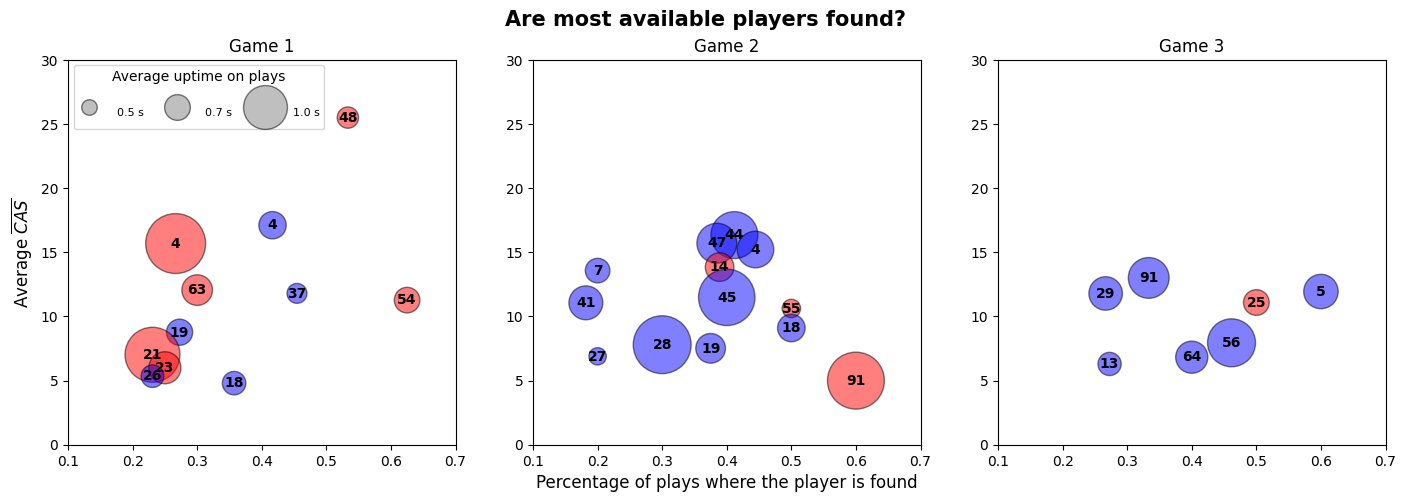

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle("Are most available players found?", fontweight="bold", size=15)
plot_players_disponibilities(ax1, players_mean_score_game_1, 1)
plot_players_disponibilities(ax2, players_mean_score_game_2, 2)
plot_players_disponibilities(ax3, players_mean_score_game_3, 3)

##  Which player finds the best his disponible teamates?

The goal of this study is to see if the player with the puck did the pass when the score of his teamates was at his best.

In [ ]:
def get_FTCAS_data(play_action_data):
  player_finding_data = pd.DataFrame()
  ind = 0
  for key, val in play_action_data.items():
    if val['Available_teamate_found'] == True:
      player_finding_data.loc[ind, 'Player'] = val['Player_with_Puck_Id']
      player_finding_data.loc[ind, 'Team'] = val['Player_with_Puck_Team']
      player_finding_data.loc[ind, 'Available_Teamate_Found_Id'] = val['Puck_Receiver_Id']
      # Calculate how many score are behind the score at start of the pass
      player_found_score_start_of_pass = val['Score_start_of_pass'][val['Puck_Receiver_Id']]
      # Get the list of all the score during the play
      all_scores = []
      for scores in val['Scores_evolutions'].values():
        for s in scores :
          if s != 0 :
            all_scores.append(s)
      player_finding_data.loc[ind, 'Finding_Vision'] = round(len([i for i in all_scores if i < player_found_score_start_of_pass])/len(all_scores)*100,2)
      ind += 1
  # Remove when the score is equal to zero
  player_finding_data = player_finding_data[player_finding_data['Finding_Vision'] > 0].reset_index(drop=True)
  return player_finding_data

In [ ]:
FTCAS_data_game_1 = get_FTCAS_data(play_actions_data_game_1)
FTCAS_data_game_2 = get_FTCAS_data(play_actions_data_game_2)
FTCAS_data_game_3 = get_FTCAS_data(play_actions_data_game_3)

In [ ]:
def get_FTCAS_score_data(FTCAS_data):
  FTCAS_score_data = FTCAS_data.groupby(['Player', 'Team']).agg(
      mean_FTCAS=('Finding_Vision', 'mean'),
      nb_plays=('Finding_Vision', 'size')
  ).reset_index().sort_values(by="mean_FTCAS", ascending=False).reset_index(drop=True)
  # Keep only players with more than 3 passes
  FTCAS_score_data = FTCAS_score_data[FTCAS_score_data["nb_plays"]>3].reset_index(drop=True)
  FTCAS_score_data["mean_FTCAS"] = round(FTCAS_score_data["mean_FTCAS"],2)
  return FTCAS_score_data

In [ ]:
FTCAS_score_data_game_1 = get_FTCAS_score_data(FTCAS_data_game_1)
FTCAS_score_data_game_2 = get_FTCAS_score_data(FTCAS_data_game_2)
FTCAS_score_data_game_3 = get_FTCAS_score_data(FTCAS_data_game_3)

In [ ]:
FTCAS_score_data_game_3

,Player,Team,mean_FTCAS,nb_plays
0,5,Away,76.65,8
1,29,Away,73.14,5
2,29,Home,70.57,4
3,78,Away,66.90,4
4,Go,Home,63.90,6


## Represent the play and the evolution of the scores

In [ ]:
color_list = ["black", "green", "green", "purple", "yellow"]

def plot_score_evolution(ax, score_dict, index):
    ax.clear()
    for key, val in score_dict.items() :
      ax.plot(val[:index],
              color=score_dict_players_colors[key],
              label="Player {}".format(key))
    ax.legend(loc="upper right")
    ax.set_ylim(0,110)
    ax.set_xlim(0,len(val))
    ax.set_xlabel('time ellapsed (sec)')
    ax.set_ylabel('Close Availability Score (CAS)')
    # Change the x labels
    new_labels_positions = np.linspace(1,len(val)-1,5)
    ax.set_xticks(new_labels_positions)
    ax.set_xticklabels([round(i*0.0333,2) for i in new_labels_positions])

def draw_frame_polygons(ax, frame_id, tracking_data, polygons_coord):
    # Effacer les éléments précédents
    ax.cla()

    background_image = mpimg.imread('/data/NHL_Hockey_Rink.png')
    ax.imshow(background_image, extent=[-100, 100, -42.5, 42.5], aspect='auto')

    ########################## Get the data ##########################
    # Filtrer les données pour la frame actuelle
    img_tracking_data = tracking_data[tracking_data["Image Id"] == frame_id].reset_index(drop=True)
    img_tracking_data_players = img_tracking_data[img_tracking_data["Team"] != "Puck"].reset_index(drop=True)
    img_tracking_data_puck = img_tracking_data[img_tracking_data["Team"] == "Puck"].reset_index(drop=True)
    img_tracking_data_players["Team_Color"] = ["red" if i == "Home" else "blue" for i in img_tracking_data_players["Team"]]

    ########################## Update the figure ##########################

    # Dessiner les régions
    for region_id, region_info in polygons_coord.items():
        x, y = region_info["X_Y_Coord"]
        c = region_info["Color"]
        if (region_info['Player_Id'] in list(score_dict_players_colors.keys())) and (region_info['Team'] == action_team):
          e_c = score_dict_players_colors[region_info['Player_Id']]
          b_w = 5
        else :
          e_c = region_info["Border_Color"]
          b_w = region_info["Border_Width"]

        ax.fill(x, y, c, alpha=0.5, edgecolor=e_c, linewidth=b_w)

    # Add the players
    ax.scatter(img_tracking_data_players["Rink Location X (Feet)"],
               img_tracking_data_players["Rink Location Y (Feet)"],
               color=img_tracking_data_players["Team_Color"])

    ax.scatter(0, 200, color="red", label="Home team players")
    ax.scatter(0, 200, color="blue", label="Away team players")

    # Add the puck
    ax.scatter(img_tracking_data_puck["Rink Location X (Feet)"],
               img_tracking_data_puck["Rink Location Y (Feet)"],
               color="black", label="Puck")

    ax.set_xlim(list(img_tracking_data_puck["Rink Location X (Feet)"])[0]-40, list(img_tracking_data_puck["Rink Location X (Feet)"])[0]+40)
    ax.set_ylim(list(img_tracking_data_puck["Rink Location Y (Feet)"])[0]-40, list(img_tracking_data_puck["Rink Location Y (Feet)"])[0]+40)

    # Add the legend
    ax.legend(loc="upper left")

    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

def animate(f_id):
    # Récupérer les données nécessaires pour cette frame
    frame_id = ids[f_id]
    polygons_coord = get_img_voronoi_diagram(frame_id)
    draw_frame_polygons(ax1, frame_id, tracking_data=game_1_tracking, polygons_coord=polygons_coord)
    plot_score_evolution(ax2, score_dict, f_id)

################################################################################

# Initialiser la figure
ratios = [1, 1]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), gridspec_kw={'width_ratios': ratios})
fig.suptitle("Visualisation of the Close Availability Score ($CAS$) evolution.", fontsize=16)
action_data = game_1_tracking[game_1_tracking["Image Id"].isin(play_actions_data_game_1['277']["Image_Ids"])]
ids = sorted(list(pd.unique(action_data["Image Id"])))
timestamps = range(len(ids))

action_team = play_actions_data_game_1['277']['Player_with_Puck_Team']
score_dict = play_actions_data_game_1['277']["Scores_evolutions"]
score_dict_players = score_dict.keys()
score_dict_players_colors = {i:j for i,j in zip(score_dict_players, color_list[:len(score_dict_players)])}
index = 0
ani = FuncAnimation(fig, animate, frames=timestamps, interval=1000/30)

plt.close()

In [ ]:
ani